## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [126]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from skimage import io

import matplotlib.image as mpimg
import seaborn as sns
from random import sample
from itertools import chain

import sklearn.model_selection as skl

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


## Do some early processing of your metadata for easier model training:

In [127]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
65921,00016291_005.png,Effusion|Nodule,5,16291,53,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00016291_005.png
3916,00001075_016.png,Effusion|Infiltration|Pneumothorax,16,1075,59,F,AP,3056,2544,0.139000,0.139000,NaN,/data/images_001/images/00001075_016.png
112083,00030779_000.png,No Finding,0,30779,18,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030779_000.png


In [128]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
80315,00019741_000.png,No Finding,0,19741,52,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63613,00015700_005.png,Atelectasis|Infiltration,5,15700,47,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
725,00000181_028.png,Consolidation|Infiltration,28,181,50,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
all_xray_df.iloc[:,-2].sample(3)

20150    0.0
47084    0.0
59140    0.0
Name: Pneumonia, dtype: float64

In [130]:
all_xray_df['pneumonia_class']= all_xray_df.iloc[:,-2].astype(str)

In [131]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
111672,00030583_000.png,Infiltration,0,30583,51,M,PA,2021,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28518,00007442_003.png,Infiltration,3,7442,35,F,AP,2500,2048,0.171000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17749,00004801_000.png,No Finding,0,4801,88,M,PA,2606,2745,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [132]:
len(all_xray_df)

112120

In [133]:
train_df, valid_df = skl.train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df['Pneumonia'])
    

In [134]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [135]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

In [136]:
p_inds = train_df[train_df.Pneumonia ==1].index.tolist()
np_inds = train_df[train_df.Pneumonia ==0].index.tolist()

np_sample = sample(np_inds, len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [137]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [138]:
p_inds = valid_df[valid_df.Pneumonia ==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia ==0].index.tolist()

np_sample = sample(np_inds, 4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]



In [139]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

In [140]:
len(valid_df[valid_df.Pneumonia ==1])

286

In [141]:
len(valid_df[valid_df.Pneumonia ==0])

1144

## Create your training and testing data:

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [142]:
IMG_SIZE = (224,224)

In [143]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                            horizontal_flip = True,
                            vertical_flip = False,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 20,
                            shear_range = 0.1,
                            zoom_range= 0.1
                            )
train_gen = idg.flow_from_dataframe(dataframe=train_df,
                                 directory=None,
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE,
                                 batch_size = 70
                                 )
val_idg = ImageDataGenerator(rescale=1. /255.0)

val_gen = idg.flow_from_dataframe(dataframe=valid_df,
                                 directory=None,
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE,
                                 batch_size = 70
                                 )
    

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [144]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [145]:
print('Train', valX.min(), valX.max(), valX.mean(), valX.std())

Train 0.0 1.0 0.5268337 0.23995775


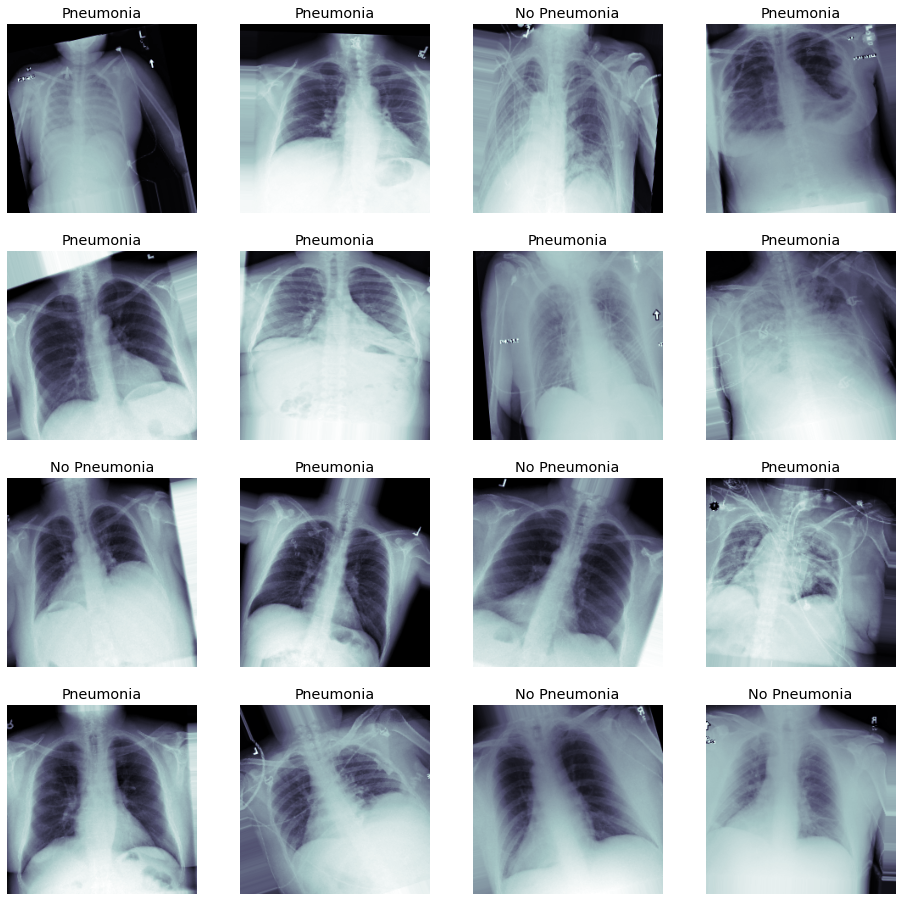

In [146]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

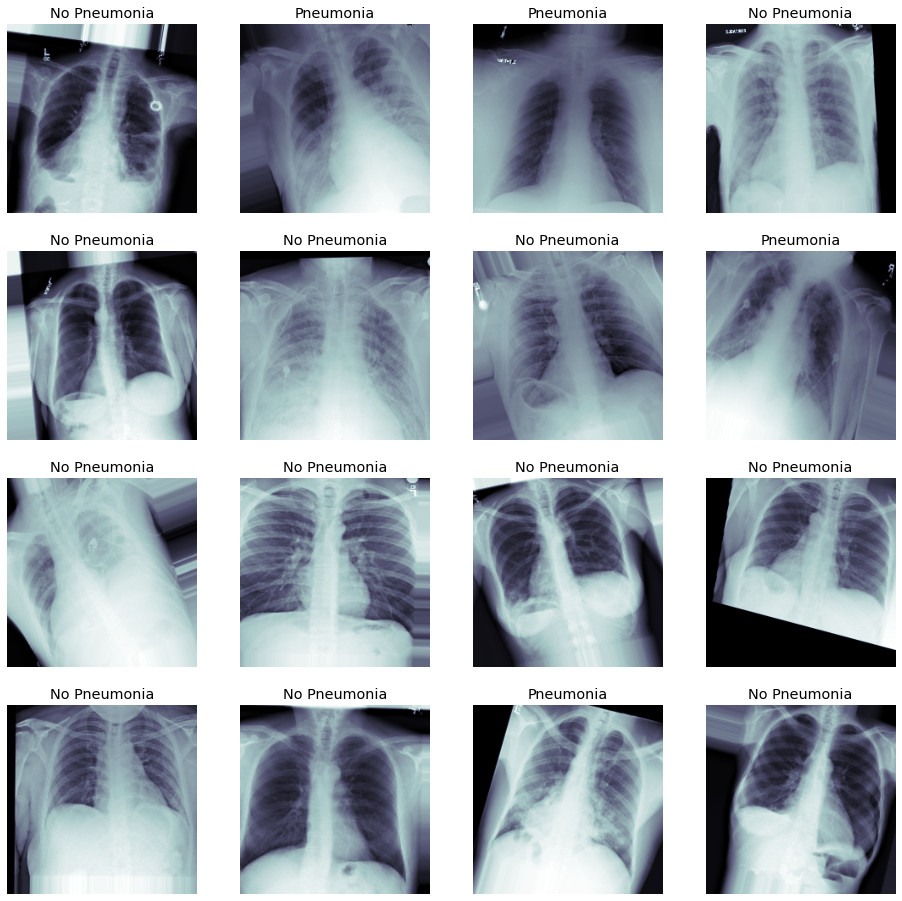

In [147]:
t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [148]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [149]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [150]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [151]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [152]:
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation = 'relu'))
my_model.add(Dense(1, activation = 'sigmoid'))

In [153]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [154]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [155]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=2)

callbacks_list = [checkpoint, early]

### Start training! 

In [156]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 8, 
                           callbacks = callbacks_list)

Epoch 1/8
33/33 [==============================] - 64s 2s/step - loss: 0.8005 - binary_accuracy: 0.5345 - val_loss: 0.6029 - val_binary_accuracy: 0.7143

Epoch 00001: val_loss improved from inf to 0.60295, saving model to xray_class_my_model.best.hdf5
Epoch 2/8
33/33 [==============================] - 60s 2s/step - loss: 0.6885 - binary_accuracy: 0.5725 - val_loss: 0.5755 - val_binary_accuracy: 0.7286

Epoch 00002: val_loss improved from 0.60295 to 0.57552, saving model to xray_class_my_model.best.hdf5
Epoch 3/8
33/33 [==============================] - 59s 2s/step - loss: 0.6615 - binary_accuracy: 0.6109 - val_loss: 0.6358 - val_binary_accuracy: 0.7000

Epoch 00003: val_loss did not improve from 0.57552
Epoch 4/8
33/33 [==============================] - 59s 2s/step - loss: 0.6529 - binary_accuracy: 0.6183 - val_loss: 0.7039 - val_binary_accuracy: 0.5714

Epoch 00004: val_loss did not improve from 0.57552


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [157]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

70/70 [==============================] - 2s 25ms/step


In [158]:
import sklearn.metrics as sklm
>>> fpr, tpr, thresholds = sklm.roc_curve(valY, pred_Y, pos_label=None)



In [159]:
fpr

array([0.        , 0.01612903, 0.03225806, 0.03225806, 0.11290323,
       0.11290323, 0.25806452, 0.25806452, 0.43548387, 0.43548387,
       0.4516129 , 0.4516129 , 0.70967742, 0.70967742, 0.77419355,
       0.77419355, 1.        ])

In [160]:
tpr

array([0.   , 0.   , 0.   , 0.25 , 0.25 , 0.375, 0.375, 0.5  , 0.5  ,
       0.625, 0.625, 0.75 , 0.75 , 0.875, 0.875, 1.   , 1.   ])

In [161]:
thresholds

array([1.7769394 , 0.77693945, 0.7272756 , 0.67302895, 0.55915284,
       0.55686873, 0.49167064, 0.49076334, 0.41641364, 0.4155416 ,
       0.40990496, 0.40758342, 0.34620973, 0.34401277, 0.3331956 ,
       0.33091146, 0.12950304], dtype=float32)

In [162]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.preprocessing import binarize
precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)


(<matplotlib.legend.Legend at 0x7f68f6934a50>,)

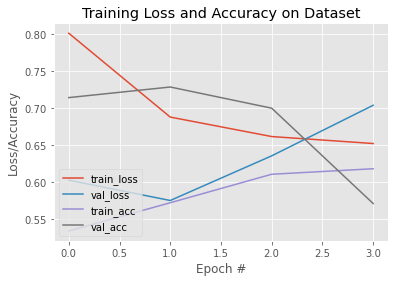

In [163]:

N = len(history.history["loss"])

plt.style.use("ggplot")

plt.figure()

plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")

plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")

plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy on Dataset")

plt.xlabel("Epoch #")

plt.ylabel("Loss/Accuracy")

plt.legend(loc="lower left"),


Text(0, 0.5, 'True Positive Rate')

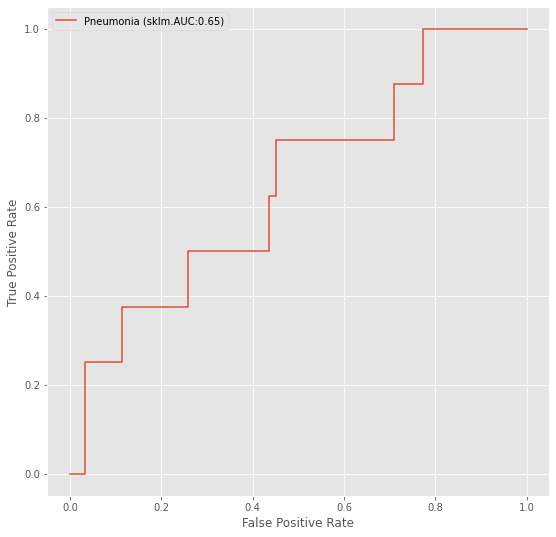

In [164]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = sklm.roc_curve(valY, pred_Y)
c_ax.plot(fpr, tpr, label = '%s (sklm.AUC:%0.2f)'  % ('Pneumonia', sklm.auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

Text(0, 0.5, 'Precision')

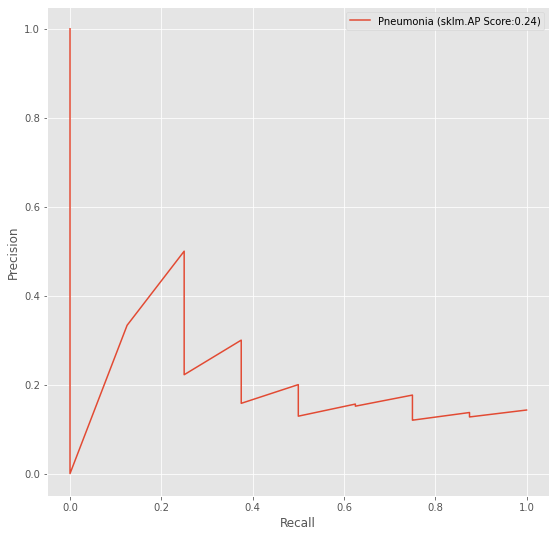

In [165]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
precision, recall, thresholds = sklm.precision_recall_curve(valY, pred_Y)
c_ax.plot(recall, precision, label = '%s (sklm.AP Score:%0.2f)'  % ('Pneumonia', sklm.average_precision_score(valY, pred_Y)))
c_ax.legend()
c_ax.set_xlabel('Recall')
c_ax.set_ylabel('Precision')

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [41]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.


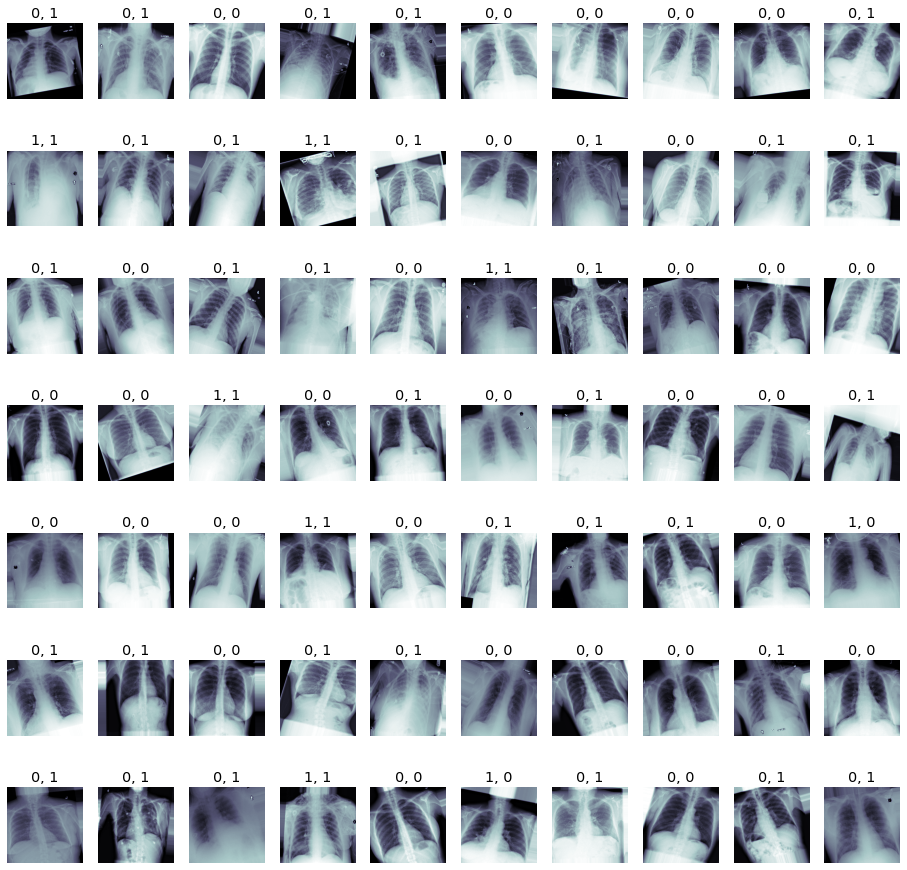

In [170]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(7, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:70], valY[0:70], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > 0.38:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > 0.38: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [171]:
model.save('my_model')
model.save_weights('xray_class_my_model')

In [172]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)